In [2]:
# Load packages
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import os
import scipy as scp
import scipy.stats as scps
from scipy.optimize import differential_evolution
from scipy.optimize import minimize
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load my own functions
import dnnregressor_train_eval_keras as dnnk
import make_data_wfpt as mdw
from kde_training_utilities import kde_load_data
import ddm_data_simulation as ddm_sim

In [6]:
# Load Model
model_path = os.getcwd() + '/keras_models/ddm_kde_hyp_opt_test_kde_ddm_small_fan_out_04_23_19_15_28_09/model_0' 
ckpt_path = os.getcwd() + '/keras_models/ddm_kde_hyp_opt_test_kde_ddm_small_fan_out_04_23_19_15_28_09/ckpt_0_85'
model = keras.models.load_model(model_path)
model.load_weights(ckpt_path)

In [7]:
# Define the likelihood function
def log_p(params = [0, 1, 0.9], model = [], data = []):
    feature_pd = pd.DataFrame(np.zeros((data[0].shape[0], 5)), columns = ['v', 'a', 'w', 'rt', 'choice'])
    feature_pd['rt'] = data[0]
    feature_pd['choice'] = data[1]
    feature_pd['v'] = params[0]
    feature_pd['a'] = params[1]
    feature_pd['w'] = params[2]
    prediction = model.predict(feature_pd)
    prediction[prediction < 1e-29] = 1e-29
    return(- np.sum(np.log(prediction)))

In [13]:
# Run MLE 

# Initializations -----
n_runs = 1
n_samples = 5000
v_range = [-2.5, 2.5]
a_range = [0.5, 3]
w_range = [0.15, 0.85]

optim_results = pd.DataFrame(np.zeros((n_runs, 7)), columns = ['v_sim', 
                                                               'a_sim', 
                                                               'w_sim', 
                                                               'v_mle', 
                                                               'a_mle', 
                                                               'w_mle', 
                                                               'n_samples'])
# ---------------------

# Main loop ----------- TD: Parallelize
cnt = 1
for i in range(0, n_runs, 1): 
    
    # Sample parameters
    v_sim = np.random.uniform(high = v_range[1], low = v_range[0])
    a_sim = np.random.uniform(high = a_range[1], low = a_range[0])
    w_sim = np.random.uniform(high = w_range[1], low = w_range[0])
    
    # Store in output file
    optim_results.iloc[i, 0:3] = [v_sim, a_sim, w_sim]
    optim_results.iloc[i, 6] = n_samples
    
    ddm_dat_tmp = ddm_sim.ddm_simulate(a = a_sim, 
                                       v = v_sim, 
                                       w = w_sim, 
                                       n_samples = n_samples)
    
    
    # Run optimizer
    out = differential_evolution(log_p, 
                                 bounds = [(v_range[0],v_range[1]), 
                                           (a_range[0], a_range[1]), 
                                           (w_range[0], w_range[1])], 
                                 args = (model, ddm_dat_tmp), 
                                 popsize = 30)
    
#     out = minimize(log_p,
#                    x0 = np.array([0, 1, 0.5]),
#                    bounds = [(v_range[0],v_range[1]), 
#                                            (a_range[0], a_range[1]), 
#                                            (w_range[0], w_range[1])],
#                   args = (model, ddm_dat_tmp),
#                   method = 'Nelder-Mead'
#                   )
    
    # Print current result
    print(out.x)
    
    # Store result in output file
    optim_results.iloc[i, 3:6] = out.x
    
    #Print and update counter
    print(cnt)
    cnt += 1
# -----------------------

0  datapoints sampled
1000  datapoints sampled
2000  datapoints sampled
3000  datapoints sampled
4000  datapoints sampled
finished: {'v': -1.494173052372204, 'a': 1.1544464649205652, 'w': 0.25411016650589496, 's': 1, 'delta_t': 0.001, 'max_t': 20, 'n_samples': 5000, 'simulator': 'ddm', 'boundary_fun_type': 'constant'}
[-1.18073124  1.10519633  0.22664446]
1


In [5]:
optim_results.to_csv(os.getcwd() + '/experiments/ddm_kde_mle_1/optim_results_nelder_mead.csv')

In [14]:
optim_results

,v_sim,a_sim,w_sim,v_mle,a_mle,w_mle,n_samples
0,-1.494173,1.154446,0.25411,-1.180731,1.105196,0.226644,5000.0


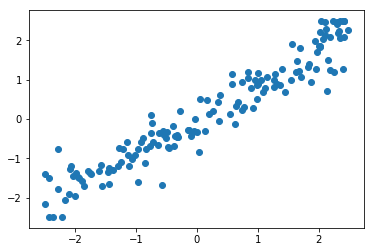

In [10]:
plt.scatter(optim_results['v_sim'], optim_results['v_mle'])

In [37]:
# Regression for v
reg = LinearRegression().fit(np.expand_dims(optim_results['v_mle'], 1), np.expand_dims(optim_results['v_sim'], 1))
reg.score(np.expand_dims(optim_results['v_mle'], 1), np.expand_dims(optim_results['v_sim'], 1))

0.9174881140826349

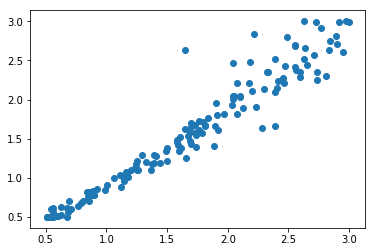

In [11]:
plt.scatter(optim_results['a_sim'], optim_results['a_mle'])

In [36]:
# Regression for a
reg = LinearRegression().fit(np.expand_dims(optim_results['a_mle'], 1), np.expand_dims(optim_results['a_sim'], 1))
reg.score(np.expand_dims(optim_results['a_mle'], 1), np.expand_dims(optim_results['a_sim'], 1))

0.9341689917325401

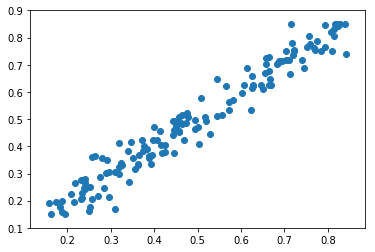

In [14]:
plt.scatter(optim_results['w_sim'], optim_results['w_mle'])

In [35]:
# Regression for w
reg = LinearRegression().fit(np.expand_dims(optim_results['w_mle'], 1), np.expand_dims(optim_results['w_sim'], 1))
reg.score(np.expand_dims(optim_results['w_mle'], 1), np.expand_dims(optim_results['w_sim'], 1))

0.9535084220225417

In [5]:
np.array([1,2,3])

array([1, 2, 3])